In [2]:
import pandas as pd
import numpy as np
import json
import pickle
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import dataframe_image as dfi

from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score

In [3]:
bars_color="gray"

In [4]:

def plot_figure(fig_width=2, fig_height=2):
    #define apeearance of figures

    COLOR = 'black'


    # Edit the font, font size, color and axes width

    plt.rcParams['font.size'] = 15
    plt.rcParams['axes.linewidth'] = 0.5

    tick_size=3
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['axes.edgecolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR


    # Create figure object and store it in a variable called 'fig'
    fig = plt.figure(figsize=(fig_width, fig_height))

    # Add axes object to the figure that takes up entire figure
    ax = fig.add_axes([0, 0, 1, 1])


    # Edit the major and minor ticks of the x and y axes
    ax.xaxis.set_tick_params(which='major', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', right='on')

    return fig, ax






def get_metrics(y_test, y_pred):
    predicted_for_discharge = list(np.where(y_pred == False)[0])
    wrongful_discharge = y_test.reset_index(drop=True)[predicted_for_discharge].sum()/len(predicted_for_discharge)
    print(f"WRONGFUL DISCHARGE RATE: {wrongful_discharge}")

    print(f"F1_SCORE: {f1_score(y_test, y_pred)}")
    print(f"RECALL: {recall_score(y_test, y_pred)}")
    print(f"PRECISION: {precision_score(y_test, y_pred)}")

    

    try:
        print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
    except: "ROC AUC curve could not be calculated"




def check_for_bias(df_test, column_name, preds_proba_column, threshold=0.5, min_size=0):
    df = df_test.copy().dropna()

    sub_groups = []
    wrongful_discharges = []
    lengths = []

    for sub_group in df[column_name].unique():
        df_subgroup = df[df[column_name] == sub_group]
        y_test = df_subgroup["readmitted"]
            #y_pred_test = pipeline.predict(X_test)
        if len(y_test)>=min_size:

            best_preds_test = df_subgroup[preds_proba_column]>threshold

                
            predicted_for_discharge = list(np.where(best_preds_test == False)[0])
            wrongful_discharge = y_test.reset_index(drop=True)[predicted_for_discharge].sum()/len(predicted_for_discharge)

            sub_groups.append(sub_group)
            wrongful_discharges.append(wrongful_discharge)
            lengths.append(len(df_subgroup))

    df = pd.DataFrame([sub_groups, wrongful_discharges, lengths]).transpose()
    df.columns =["sub_group", "readmittion_rate", "size_of_test_data"]
    #df.hist
    return df

            



In [5]:
with open('columns.json') as fh:
    columns = json.load(fh)


with open('dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)

In [6]:
df_test = pd.read_csv("test_set.csv")


In [7]:
for algorithm in ["LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "GradientBoostingClassifier", "SVC"]:
    pipeline = joblib.load("pipelines/pipeline_"+algorithm+".pickle")
    if algorithm=="SVC":
        df_test["pred_proba_"+algorithm] = pipeline.predict(df_test[columns])
        df_test["pred_proba_"+algorithm] = df_test["pred_proba_"+algorithm].replace([True, False], [1, 0])
    else:
        df_test["pred_proba_"+algorithm] = pipeline.predict_proba(df_test[columns])[:, 1]
    
    print(pipeline.named_steps['gridsearchcv'].best_params_)



{'C': 0.01, 'penalty': 'l2'}
{'max_depth': 5}
{'max_depth': 5, 'n_estimators': 500}
{'max_depth': 3, 'n_estimators': 100}
{'C': 1, 'kernel': 'rbf'}


In [25]:
data = df_test.copy()
algorithm = "RandomForestClassifier"
for group in ["age", "gender", "race", "isInsured", "medical_specialty"]:
    R_df = check_for_bias(df_test, group,  "pred_proba_"+algorithm, 0.5, min_size=49)
    R_df["Yes"] = (R_df.readmittion_rate*R_df.size_of_test_data).astype(int)
    R_df["No"] = (R_df.size_of_test_data-R_df.Yes)
    R_df[group] = R_df["sub_group"]
    R_df[[group, "Yes", "No"]].to_csv(f"{algorithm}_{group}_df.csv", index=False)
    

,medical_specialty,Yes,No
0,Family/GeneralPractice,30,562
1,Emergency/Trauma,114,1299
2,Surgery-General,23,321
3,Radiologist,19,203
4,InternalMedicine,64,1108
5,Surgery-Vascular,5,71
6,Orthopedics,12,181
7,Urology,4,47
8,Cardiology,24,455
9,Surgery-Cardiovascular/Thoracic,8,61


In [ ]:

algorithms = ["LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "GradientBoostingClassifier", "SVC"]
for group in ["race", "age", "gender", "isInsured", "medical_specialty", "admission_source_code"]:

    best_subgroups = []
    worst_subgroups = []
    max_rates = []
    min_rates =[]

    for algorithm in algorithms:
        

        
        data_to_plot = check_for_bias(df_test, group,  "pred_proba_"+algorithm, 0.5, min_size=49)
        data_to_plot = data_to_plot.sort_values(by="sub_group")
        data_to_plot.readmittion_rate = data_to_plot.readmittion_rate*100
        fig, ax = plot_figure(5)

        sep = np.sqrt(list(data_to_plot["readmittion_rate"].values*(100- data_to_plot["readmittion_rate"].values)/(data_to_plot["size_of_test_data"].values)))
        ax.bar(data_to_plot["sub_group"], data_to_plot["readmittion_rate"].values, yerr = sep, color = bars_color)
        plt.xticks(rotation=90)
        plt.title(algorithm)

        ax.set_ylabel("% of readmissions")
        ax.set_xlabel(group)
        ax.set_ylim([0, 30])

        max_rate = max(data_to_plot.readmittion_rate)
        min_rate = min(data_to_plot.readmittion_rate)
        max_rate_subgroup = data_to_plot.sub_group.iloc[np.where(data_to_plot.readmittion_rate == max_rate)].values[0]
        min_rate_subgroup = data_to_plot.sub_group.iloc[np.where(data_to_plot.readmittion_rate == min_rate)].values[0]

        print(algorithm)
        print(max_rate_subgroup, max_rate)
        print(min_rate_subgroup, min_rate)
        print(max_rate-min_rate)
        print("#######")

        best_subgroups.append(min_rate_subgroup)
        worst_subgroups.append(max_rate_subgroup)
        max_rates.append(max_rate)
        min_rates.append(min_rate)

    df = pd.DataFrame([algorithms,worst_subgroups, max_rates,  best_subgroups, min_rates, [mx-mn for mx, mn in zip(max_rates, min_rates)]])
    df = df.transpose()
    df.columns = ["Classifier", "Group with highest rate", "Highest rate", "Group with lowest rate", "Lowest rate", "Difference"]
    df = df.set_index("Classifier", drop = True)
    df_styled = df.style.background_gradient()
    dfi.export(df_styled, group+"_table.png")


In [44]:

algorithms = ["LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "GradientBoostingClassifier", "SVC"]
features = ["race", "age", "gender", "isInsured", "medical_specialty"]
for algorithm in algorithms:

    best_subgroups = []
    worst_subgroups = []
    max_rates = []
    min_rates =[]

    for group in features:
        
        data_to_plot = check_for_bias(df_test, group,  "pred_proba_"+algorithm, 0.5, min_size=49)
        data_to_plot = data_to_plot.sort_values(by="sub_group")
        data_to_plot.readmittion_rate = data_to_plot.readmittion_rate*100

        max_rate = max(data_to_plot.readmittion_rate)
        min_rate = min(data_to_plot.readmittion_rate)
        max_rate_subgroup = data_to_plot.sub_group.iloc[np.where(data_to_plot.readmittion_rate == max_rate)].values[0]
        min_rate_subgroup = data_to_plot.sub_group.iloc[np.where(data_to_plot.readmittion_rate == min_rate)].values[0]

        print(algorithm)
        print(max_rate_subgroup, max_rate)
        print(min_rate_subgroup, min_rate)
        print(max_rate-min_rate)
        print("#######")

        best_subgroups.append(min_rate_subgroup)
        worst_subgroups.append(max_rate_subgroup)
        max_rates.append(max_rate)
        min_rates.append(min_rate)

    df = pd.DataFrame([features,worst_subgroups, max_rates,  best_subgroups, min_rates, [mx-mn for mx, mn in zip(max_rates, min_rates)]])
    df = df.transpose()
    df.columns = ["Feature", "Group with highest rate", "Highest rate", "Group with lowest rate", "Lowest rate", "Difference"]
    df = df.set_index("Feature", drop = True)
    df_styled = df.style.background_gradient()
    dfi.export(df_styled, algorithm+"_table.png")


LogisticRegression
Other 12.068965517241379
Hispanic 0.0
12.068965517241379
#######
LogisticRegression
[90-100) 9.230769230769232
[30-40) 3.816793893129771
5.41397533763946
#######
LogisticRegression
Male 7.2565245066836415
Female 6.904109589041097
0.3524149176425446
#######
LogisticRegression
True 7.302231237322515
False 5.47945205479452
1.822779182527995
#######
LogisticRegression
Pulmonology 12.195121951219512
Psychiatry 2.380952380952381
9.814169570267131
#######


[0205/204159.670474:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0205/204200.288083:INFO:headless_shell.cc(648)] Written to file /tmp/tmpfj7grv49/temp.png.


DecisionTreeClassifier
Other 8.88888888888889
Hispanic 0.0
8.88888888888889
#######
DecisionTreeClassifier
[60-70) 8.345323741007196
[30-40) 2.083333333333333
6.261990407673863
#######
DecisionTreeClassifier
Female 6.642857142857143
Male 6.3028439661798625
0.3400131766772807
#######
DecisionTreeClassifier
True 6.567796610169492
False 5.865102639296188
0.7026939708733044
#######
DecisionTreeClassifier
Gastroenterology 15.0
Psychiatry 4.166666666666666
10.833333333333334
#######


[0205/204201.813970:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0205/204202.350359:INFO:headless_shell.cc(648)] Written to file /tmp/tmp3p_nir_g/temp.png.


RandomForestClassifier
Other 9.803921568627452
Hispanic 1.5873015873015872
8.216619981325865
#######
RandomForestClassifier
[60-70) 8.047493403693931
[30-40) 2.6548672566371683
5.392626147056763
#######
RandomForestClassifier
Male 6.844626967830253
Female 6.282722513089005
0.5619044547412484
#######
RandomForestClassifier
True 6.625813864419762
False 6.084656084656085
0.5411577797636777
#######
RandomForestClassifier
Surgery-Cardiovascular/Thoracic 12.5
Psychiatry 2.564102564102564
9.935897435897436
#######


[0205/204204.284283:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0205/204204.888672:INFO:headless_shell.cc(648)] Written to file /tmp/tmpf0cjdov8/temp.png.


GradientBoostingClassifier
Other 10.909090909090908
Hispanic 0.0
10.909090909090908
#######
GradientBoostingClassifier
[60-70) 8.418367346938775
[30-40) 2.7027027027027026
5.715664644236072
#######
GradientBoostingClassifier
Female 6.587537091988131
Male 6.583278472679395
0.004258619308735945
#######
GradientBoostingClassifier
True 6.640485540878258
False 6.20347394540943
0.43701159546882806
#######
GradientBoostingClassifier
Nephrology 11.956521739130435
Psychiatry 2.3255813953488373
9.630940343781598
#######


[0205/204206.644821:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0205/204207.231219:INFO:headless_shell.cc(648)] Written to file /tmp/tmpyl0weguj/temp.png.


SVC
African American 9.090909090909092
Hispanic 0.0
9.090909090909092
#######
SVC
[90-100) 8.620689655172415
[30-40) 3.225806451612903
5.394883203559512
#######
SVC
Male 7.156798959011061
Female 6.402793946449361
0.7540050125617004
#######
SVC
True 6.873457878040183
False 5.980861244019139
0.8925966340210438
#######
SVC
Pulmonology 13.157894736842104
Psychiatry 2.5
10.657894736842104
#######


[0205/204209.141451:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0205/204209.693174:INFO:headless_shell.cc(648)] Written to file /tmp/tmp1gvy13dg/temp.png.


In [1]:
df_styled

NameError: name 'df_styled' is not defined

In [40]:
df

,Group with highest rate,Highest rate,Group with lowest rate,Lowest rate,Difference
Classifier,,,,,
LogisticRegression,African American,9.090909,Hispanic,0.0,9.090909
DecisionTreeClassifier,[90-100),8.62069,[30-40),3.225806,5.394883
RandomForestClassifier,Male,7.156799,Female,6.402794,0.754005
GradientBoostingClassifier,True,6.873458,False,5.980861,0.892597
SVC,Pulmonology,13.157895,Psychiatry,2.5,10.657895
NaN,5.0,10.0,1.0,6.373938,3.626062


[0.52352589]
[0.19179856]
[0.49206349]


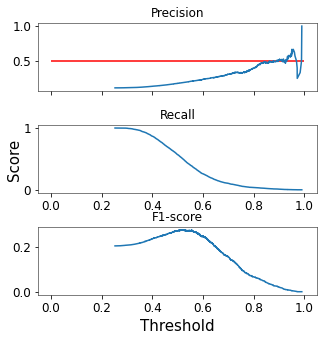

[0.55555556]
[0.18753727]
[0.464378]


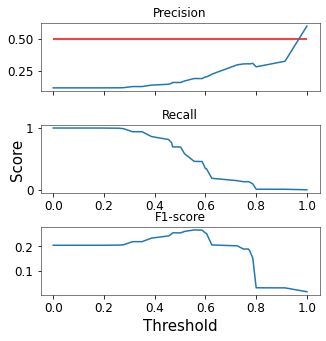

[0.52526524]
[0.19338648]
[0.48357327]


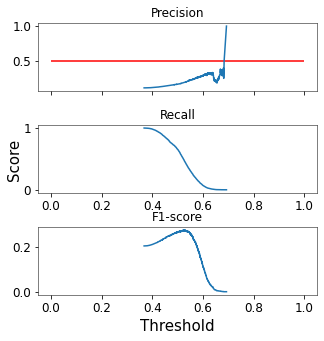

[0.52022898]
[0.18740592]
[0.55149502]


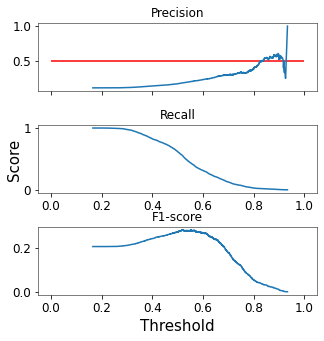

In [38]:
for algorithm in ["LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "GradientBoostingClassifier"]: #, "SVC"]:

    precision, recall, thresholds = precision_recall_curve(df_test.readmitted, df_test["pred_proba_"+algorithm])

    precision = precision[:-1]
    recall = recall[:-1]
    f1_score_result = 2*precision*recall/(precision+recall)



    fig, ax = plot_figure(fig_width=5, fig_height=5)
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)

    ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
    ax1.plot(thresholds,precision)
    ax2.plot(thresholds,recall)
    ax3.plot(thresholds,f1_score_result)

    ax1.get_shared_x_axes().join(ax1, ax2, ax3)
    ax1.set_xticklabels([])
    plt.xlabel('Threshold', size=1)
    ax1.set_title('Precision', size=12)
    ax2.set_title('Recall', size=12)
    ax3.set_title('F1-score', size=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax3.tick_params(axis='both', which='major', labelsize=12)

    plt.subplots_adjust(hspace=0.5)
    fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical', size=15)


    print(thresholds[np.where(f1_score_result==max(f1_score_result))])
    print(precision[np.where(f1_score_result==max(f1_score_result))])
    print(recall[np.where(f1_score_result==max(f1_score_result))])



    plt.show()
    fig.savefig(f'{algorithm}_threshold.png', dpi=300, transparent=True, bbox_inches='tight')


                        Feature  Importance
16            blood_transfusion    0.003372
8            num_lab_procedures    0.006586
0                          race    0.010450
3    discharge_disposition_code    0.011760
9                num_procedures    0.012937
5              time_in_hospital    0.019146
7   complete_vaccination_status    0.033700
23                   age_as_int    0.085894
21                       change    0.211942
6                has_prosthesis    0.497100


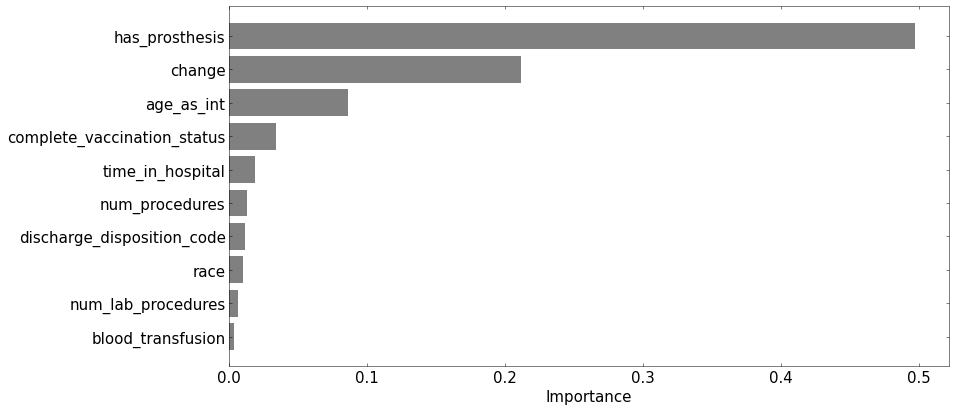

                        Feature  Importance
26            diag_3_simplified    0.021266
1                        gender    0.027391
9                num_procedures    0.032274
7   complete_vaccination_status    0.040896
0                          race    0.041557
3    discharge_disposition_code    0.048436
23                   age_as_int    0.071548
5              time_in_hospital    0.079643
21                       change    0.116407
6                has_prosthesis    0.231976


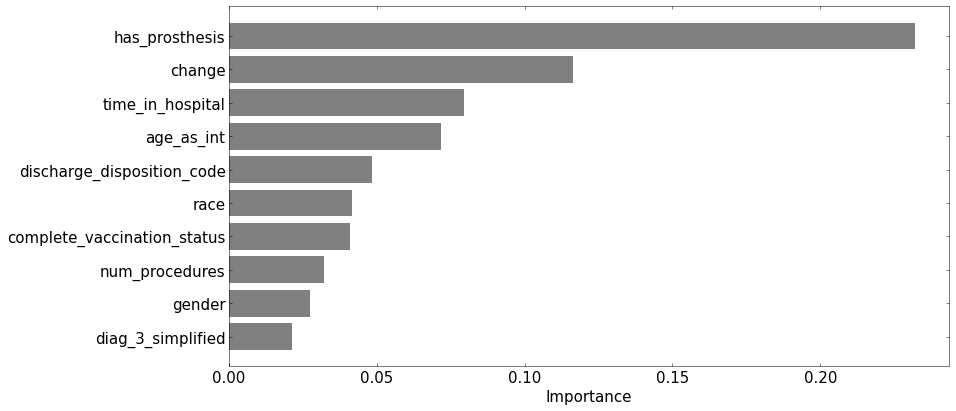

                        Feature  Importance
22                  diabetesMed    0.011998
1                        gender    0.025756
9                num_procedures    0.026333
7   complete_vaccination_status    0.029127
5              time_in_hospital    0.030957
8            num_lab_procedures    0.033896
23                   age_as_int    0.034622
3    discharge_disposition_code    0.047529
21                       change    0.121586
6                has_prosthesis    0.360875


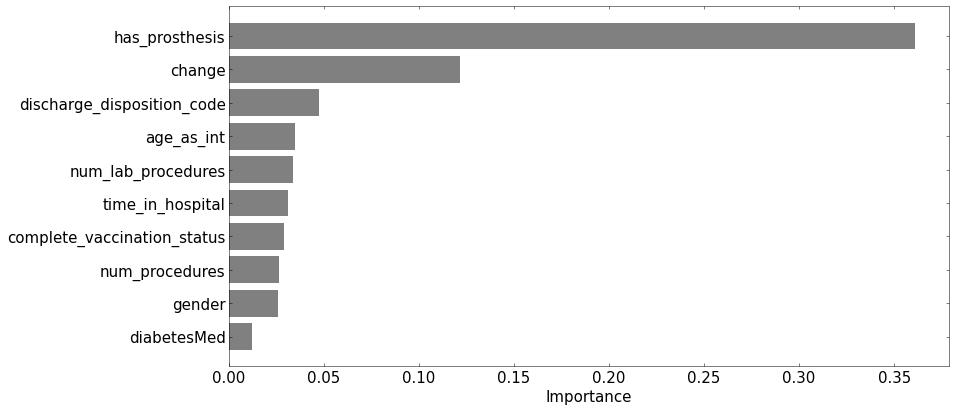

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [35]:
for algorithm in ["DecisionTreeClassifier", "RandomForestClassifier", "GradientBoostingClassifier", "SVC"]:

    # Create list of top most features based on importance
    pipeline = joblib.load(f"pipelines/pipeline_{algorithm}.pickle")

    feature_names = columns
    feature_importance = pipeline.named_steps['gridsearchcv'].best_estimator_.feature_importances_
    most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_importance)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
    most_imp_features.sort_values(by="Importance", inplace=True)
    print(most_imp_features)

    fig, ax = plot_figure(fig_width=10, fig_height=5)

    #plt.figure(figsize=(10,6))
    plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', color=bars_color)
    plt.yticks(range(len(most_imp_features)), most_imp_features.Feature)
    plt.xlabel('Importance')
    plt.show()
    fig.savefig(f'{algorithm}_feature_importance.png', dpi=300, transparent=True, bbox_inches='tight')


In [20]:
coefs = pipeline.named_steps["classifier"].coef_.flatten()

KeyError: 'classifier'

array([4.15566560e-02, 2.73907457e-02, 1.02571477e-02, 4.84355843e-02,
       2.05611900e-02, 7.96429011e-02, 2.31975676e-01, 4.08956641e-02,
       1.80114413e-02, 3.22744685e-02, 2.47696549e-03, 7.28161918e-04,
       2.14490522e-03, 2.34791240e-03, 7.56499004e-04, 1.50038941e-03,
       1.68253230e-03, 2.78555626e-03, 2.41316015e-03, 4.45771250e-03,
       3.22869158e-04, 1.16407464e-01, 3.89093033e-03, 7.15478101e-02,
       3.20244707e-04, 2.16713412e-03, 2.12659399e-02, 7.24964259e-04,
       1.18289507e-02, 6.56789981e-03, 7.96599548e-04, 3.71963322e-03,
       3.25332866e-03, 7.26087049e-04, 2.47630807e-04, 2.75167923e-03,
       1.14511772e-03, 1.12142522e-03, 3.76778714e-03, 2.26805193e-04,
       8.49590111e-04, 6.62955730e-04, 2.01201209e-03, 1.89975917e-03,
       3.36686375e-04, 1.72550466e-03, 2.26963290e-03, 1.11178972e-03,
       1.07839921e-03, 8.18034847e-05, 1.56297119e-03, 2.43727773e-03,
       7.46837742e-03, 6.91654985e-03, 1.76774736e-03, 1.33031170e-03,
      

In [25]:
dir(pipeline.named_steps['gridsearchcv'])

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_features_

In [52]:
thresholds[np.where(f1_score_result==max(f1_score_result))]

array([0.52526524])

In [55]:
precision[np.where(f1_score_result==max(f1_score_result))]

array([0.19338648])

,sub_group,readmittion_rate,size_of_test_data
0,Family/GeneralPractice,0.049661,772
1,Emergency/Trauma,0.062,1914
2,Surgery-General,0.051282,466
3,Radiologist,0.087156,297
4,Orthopedics-Reconstructive,0.03125,57
5,InternalMedicine,0.061742,1571
6,Surgery-Vascular,0.019231,98
7,Orthopedics,0.055118,247
8,Urology,0.039216,66
9,Cardiology,0.070796,632


In [ ]:
data_to_plot = check_for_bias(df_test_merge, "medical_specialty", joblib.load("pipeline_SVC.pickle"), 0.5)
data_to_plot.readmittion_rate = data_to_plot.readmittion_rate*100




(0.0, 30.0)

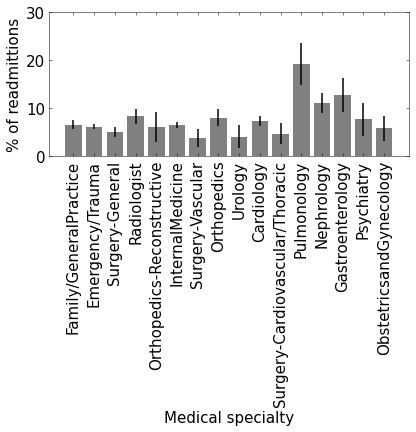

In [ ]:
fig, ax = plot_figure(5)

sep = np.sqrt(list(data_to_plot["readmittion_rate"].values*(100- data_to_plot["readmittion_rate"].values)/(data_to_plot["size_of_test_data"].values)))
ax.bar(data_to_plot["sub_group"], data_to_plot["readmittion_rate"].values, yerr = sep, color = bars_color)
plt.xticks(rotation=90)


ax.set_ylabel("% of readmittions")
ax.set_xlabel("Medical specialty")
ax.set_ylim([0, 30])

In [ ]:
data_to_plot["readmittion_rate"].values*(100- data_to_plot["readmittion_rate"].values)/data_to_plot["size_of_test_data"].values

array([0.006429629145399162, 0.0032372810867293627, 0.010999088582449428,
       0.029319865886653196, 0.05480742872807018, 0.0039276821044816205,
       0.019619460210119552, 0.022302724767392854, 0.059394405415166655,
       0.011194040947666965, 0.05148684323489011, 0.12651167302593289,
       0.039300723455700334, 0.14880642669063274, 0.08767313019390581,
       0.07735385175742122], dtype=object)

In [ ]:
# Save for deployment
with open(f'columns.json', 'w') as fh:
    json.dump(X_train_baseline.columns.tolist(), fh)
    
with open(f'dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train_baseline.dtypes, fh)
    
joblib.dump(final_pipeline, f'pipeline_logisticRegression.pickle')